In [85]:
import string
import re
import numpy as np
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

In [86]:
f = open('../../Data/text-data/ben.txt', '+r', encoding='utf-8')

In [87]:
data_text = f.read()

In [88]:
# The following function is only specific to the data that we have
def create_text_pair(data_text):
    word_pair = []
    arr = data_text.split('\n')
    for element in arr:
        try:
            element = element.replace('!','')
            element = element.replace('?','')
            element = element.replace(',','')
            element = element.replace('.','')
            element = element.replace('।','')
            arr1 = element.split('\t')
            temp = [arr1[0], arr1[1]]
            word_pair.append(temp)
        except:
            print('Exception occurred in {}'.format(element))
    return word_pair

In [89]:
word_pair = create_text_pair(data_text)

Exception occurred in 


20
January February March April May June July August September October November and December are the twelve months of the year
18
আমি ভেবেছিলাম এটা করা সহজ হবে কিন্তু আমরা সারাদিন ধরে কাজ করেছি আর এখনো শেষ করে উঠতে পারিনি


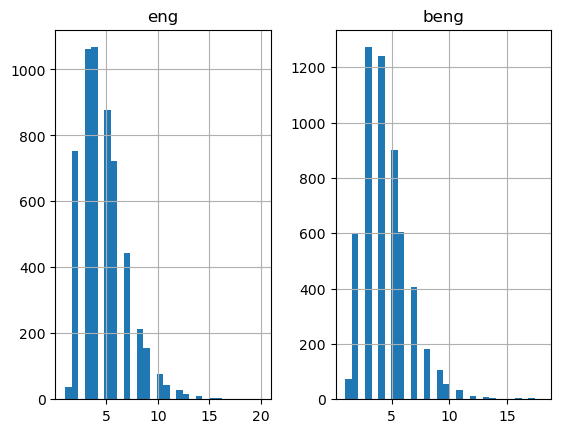

In [90]:
# Text to Sequence Conversion

'''
    A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.
    But before we do that, let’s visualise the length of the sentences. We will capture the lengths of all the sentences in 
    two separate lists for English and German, respectively.

'''

# empty lists
eng_l = []
beng_l = []

set_eng = set()
set_beng = set()

# populate the lists with sentence lengths
m= 0 
w = ''
for i in word_pair:
    tmp = i[0].split(' ')
    eng_l.append(len(tmp))
    for j in tmp:        
        set_eng.add(j)
    if len(tmp) > m:
        m = len(tmp)
        w = i[0]

print(m)
print(w)

m= 0 
w = ''
for i in word_pair:
    tmp = i[1].split(' ')
    beng_l.append(len(tmp))
    for j in tmp:        
        set_beng.add(j)
    if len(tmp) > m:
        m = len(tmp)
        w = i[1]

print(m)
print(w)

length_df = pd.DataFrame({'eng':eng_l, 'beng':beng_l})

length_df.hist(bins = 30)
plt.show()

In [91]:
# Max length of englist sentence is 
max(eng_l)

20

In [92]:
# Max length of bengali sentence is 
max(beng_l)

18

In [93]:
# function to build a tokenizer
def tokenization(lines):
      tokenizer = Tokenizer()
      tokenizer.fit_on_texts(lines)
      return tokenizer
    
# prepare english tokenizer
eng_tokenizer = tokenization(set_eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1 

# prepare bengali tokenizer
beng_tokenizer = tokenization(set_beng)
beng_vocab_size = len(beng_tokenizer.word_index) + 1 

In [94]:
beng_vocab_size

3682

In [95]:
eng_vocab_size

2307

In [96]:
#The below code block contains a function to prepare the sequences. It will also perform sequence padding to a 
#maximum sentence length as mentioned above.

# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
         # integer encode sequences
         seq = tokenizer.texts_to_sequences(lines)
         # pad sequences with 0 values
         seq = pad_sequences(seq, maxlen=length, padding='post')
         return seq    

In [97]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(word_pair, test_size=0.2, random_state = 12)

In [98]:
'''
    It’s time to encode the sentences. We will encode Englist sentences as the input sequences and Bengali sentences as
    the target sequences. This has to be done for both the train and test datasets.
'''

train_ip= []
train_op = []
for wp in train:
    train_ip.append(wp[0])
    train_op.append(wp[1])
    

test_ip= []
test_op = []
for wp in test:
    test_ip.append(wp[0])
    test_op.append(wp[1])

# prepare training data
trainX = encode_sequences(eng_tokenizer, max(eng_l), train_ip)
trainY = encode_sequences(beng_tokenizer, max(beng_l), train_op)

# prepare validation data
testX = encode_sequences(eng_tokenizer, max(eng_l), test_ip)
testY = encode_sequences(beng_tokenizer, max(beng_l), test_op)


In [108]:
len(testY[22])

18

In [110]:
filename = 'model.h1.12_dec_23'

In [109]:
'''
    We’ll start off by defining our Seq2Seq model architecture:

    For the encoder, we will use an embedding layer and an LSTM layer
    For the decoder, we will use another LSTM layer followed by a dense layer

'''


# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
      model = Sequential()
      model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
      model.add(LSTM(units))
      model.add(RepeatVector(out_timesteps))
      model.add(LSTM(units, return_sequences=True))
      model.add(Dense(out_vocab, activation='softmax'))
      return model
    

'''
    We are using the RMSprop optimizer in this model as it’s usually a good choice when working with recurrent neural 
    networks.

''' 
# model compilation
model = define_model(eng_vocab_size, beng_vocab_size, max(eng_l),  max(beng_l), 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')   


In [17]:
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

#Let’s compare the training loss and the validation loss.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

NameError: name 'model' is not defined

In [146]:
#Finally, we can load the saved model and make predictions on the unseen data – testX.
model = load_model('../../models/'+filename)

In [147]:
predict_x = model.predict(testX)
# preds=np.argmax(predict_x,axis=1)
# Now we take the argmax
preds = []

for i in predict_x:
    tmp = []
    for j in i:
        tmp.append(np.argmax(j, axis=0))
    preds.append(tmp)

35/35 [==============================] - 9s 207ms/step


In [148]:
predict_x.shape

(1103, 18, 3682)

In [149]:
preds

[[39, 3116, 838, 838, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [39, 3116, 838, 838, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [39, 3116, 3116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1633, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [39, 3116, 838, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1633, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [39, 3116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [39, 3116, 3116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [39, 3116, 3116, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [39, 3116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [39, 3116, 3116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1633, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1633, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1633, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1633, 3116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1633, 3116, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [3

In [150]:
# These predictions are sequences of integers. We need to convert these integers to their corresponding words. 
# Let’s define a function to do this:

token_dict_bengali = {}
for word, index in beng_tokenizer.word_index.items():
    token_dict_bengali[index] = word
    
def convert_to_words(sentence):
    temp = ''
    for i in sentence:
        if i in token_dict_bengali:
           temp += token_dict_bengali[i]+' '
    return temp.strip()

preds_text = []
for i in preds:
    preds_text.append(convert_to_words(i))

In [151]:
# Now let us see how we did
pred_df = pd.DataFrame({'actual' : test_op, 'predicted' : preds_text})

In [152]:
pred_df.sample(15)

,actual,predicted
261,আমি কাছাকাছিই থাকবো,নিয়ম জোড়া
843,আজ গরম আছে,নিয়ম জোড়া
662,সে উঠে দাঁড়ালো,নিয়ম অফিস
860,সোমবার আপনি কোথায় যাচ্ছেন,পারো জোড়া জোড়া ৩০
254,মেরি যে কোনো গয়ণা পরে সেটা টম চাইত না,পারো জোড়া সাদা সাদা
440,আমি জানি না,নিয়ম
616,টম সারা রাত কেঁদেছিল,পারো জোড়া জোড়া
360,আমি স্ট্যাম্প কোথা থেকে কিনতে পারব,পারো জোড়া জোড়া
876,আমিও ১৭,নিয়ম অফিস
963,শ্রেণীকক্ষের মধ্যে অল্পসংখ্যক ছাত্র বাকি ছিল,পারো জোড়া সাদা সাদা ৩০
